In [2]:
#import os
import sys
sys.path.append("../python/")
from helpers import *
#import pickle
import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as tkr
from itertools import combinations
from scipy.stats import ttest_ind, f_oneway # for independent t-test

In [3]:
SENSITIVITY_RESULTS_DIR = '../../results/sensitivity-tests-07272021' #'../../results/sensitivity-tests-02272021'
SCENARIO_LIST = ["Pr_Im", "PrPo_Im", "Pr_PoIm", "Pr_Po_Im"]
IMAGE_WIDTH_LIST = [189, 252, 336]

In [4]:
def getPerformanceDataFrame():
    result_file_list = getListOfFiles(SENSITIVITY_RESULTS_DIR)
    df = pd.DataFrame()
    for filename in result_file_list:
        if "scenario-resolution-" in filename:
            performance_dict = json.load(open(filename))
            performance_df = pd.DataFrame(performance_dict["metrics"])
            performance_df['epoch'] = performance_df.index + 1
            performance_df["width"] = performance_dict["image_width"]
            performance_df["height"] = performance_dict["image_height"]
            performance_df["scenario"] = performance_dict["scenario"]
            #performance_df["best_val_accuracy"] = performance_dict["best_val_accuracy"]
            performance_df["trial"] = int(filename.split("-")[-1].split(".")[0])
            df = df.append(performance_df, ignore_index=True)    
    return(df)

In [21]:
def getScenarioResolutionMeanPerformance(objective="val_accuracy"):
    dp = getPerformanceDataFrame()
    #print(dp.head())
    #dpagg = dp.groupby(['scenario','width', 'height','trial','epoch']).agg('max')
    df = dp.loc[dp.groupby(['scenario','width', 'height', 'trial'])[objective].idxmax()]
    print(df.head())
    df = df.iloc[:,[3, 4, 5, 6, 8, 10]]  #val_accuracy 	val_f1 	val_recall 	val_precision scenario
    df = df.groupby(['scenario','width']).agg(['mean','std'])
    df = np.round(df, 2)
    df = df.reindex(index=["Pr_Im", "PrPo_Im", "Pr_PoIm", "Pr_Po_Im"], level=0)
    df.to_csv('../../results/scenario-resolution-best-mean-std-performance-obj-' + objective + '.csv')    
    return df

In [22]:
getScenarioResolutionMeanPerformance('val_f1')

          loss  accuracy  val_loss  val_accuracy    val_f1  val_recall  \
1103  0.632537  0.665100  0.720764      0.671362  0.506944    0.528139   
11    0.590220  0.701528  0.600305      0.643192  0.559150    0.557823   
481   1.089942  0.593419  1.383120      0.671362  0.542638    0.549011   
376   0.566578  0.696827  0.702485      0.600939  0.555651    0.560606   
612   0.587648  0.674883  0.688949      0.561321  0.532075    0.544521   

      val_precision  epoch  width  height scenario  trial  
1103       0.560185      4    189     189  PrPo_Im      1  
11         0.565339     12    189     189  PrPo_Im      2  
481        0.578130      2    189     189  PrPo_Im      3  
376        0.555545     17    189     189  PrPo_Im      4  
612        0.538764     13    189     189  PrPo_Im      5  


val_accuracy       val_f1       val_recall       val_precision  \
                       mean   std   mean   std       mean   std          mean   
scenario width                                                                  
Pr_Im    189           0.83  0.02   0.55  0.02       0.54  0.01          0.59   
         252           0.79  0.07   0.53  0.02       0.54  0.02          0.57   
         336           0.83  0.04   0.51  0.06       0.53  0.04          0.49   
PrPo_Im  189           0.63  0.05   0.54  0.02       0.55  0.01          0.56   
         252           0.60  0.07   0.53  0.04       0.55  0.02          0.56   
         336           0.69  0.01   0.62  0.02       0.62  0.02          0.63   
Pr_PoIm  189           0.89  0.00   0.47  0.00       0.50  0.00          0.44   
         252           0.86  0.01   0.56  0.06       0.56  0.06          0.60   
         336           0.84  0.04   0.52  0.03       0.52  0.01          0.52   
Pr_Po_Im 189           0.60  0.05   0.41  0.03       0.42  0.02          0.45   
         252           0.61  0.04   0.41  0.02       0.41  0.03          0.44   
         336           0.64  0.03   0.42  0.02       0.42  0.02          0.44   

                      
                 std  
scenario width        
Pr_Im    189    0.08  
         252    0.06  
         336    0.08  
PrPo_Im  189    0.01  
         252    0.01  
         336    0.02  
Pr_PoIm  189    0.00  
         252    0.05  
         336    0.05  
Pr_Po_Im 189    0.07  
         252    0.02  
         336    0.05

In [392]:
print([c for c in combinations([64, 128, 224], 2)])

[(64, 128), (64, 224), (128, 224)]


In [158]:
print([ comb for comb in combinations(["Pr_Im", "PrPo_Im", "Pr_PoIm", "Pr_Po_Im"], 2)])

[('Pr_Im', 'PrPo_Im'), ('Pr_Im', 'Pr_PoIm'), ('Pr_Im', 'Pr_Po_Im'), ('PrPo_Im', 'Pr_PoIm'), ('PrPo_Im', 'Pr_Po_Im'), ('Pr_PoIm', 'Pr_Po_Im')]


In [387]:
df = dp.loc[dp.groupby(['scenario','resolution','trial'])['val_accuracy'].idxmax()]
dpagg = df.set_index(['scenario','resolution','trial'])
dpmax = dpagg.iloc[:,3:7]

In [75]:
def resolutionPerformanceComparisonStats(objective='val_accuracy'):
    dp = getPerformanceDataFrame()
    df = dp.loc[dp.groupby(['scenario','width','trial'])[objective].idxmax()]
    dpagg = df.set_index(['scenario','width','trial'])
    #print(dpagg.head())
    dpmax = dpagg.iloc[:,3:7]
    dstats = pd.DataFrame(columns= ['Scenario', 'Resolution 1', 'Resolution 2',  'Accuracy', 'F1', 'Recall', 'Precision'])
    rowcounter = 0
    for i in SCENARIO_LIST:
        for j in combinations(IMAGE_WIDTH_LIST, 2):
            dstats.loc[rowcounter, ['Scenario', 'Resolution 1', 'Resolution 2'] ] = (i, j[0], j[1])
            #print(dpmax.loc[(i, j[0])], dpmax.loc[(i, j[1])])
            tstats, pvals = ttest_ind(dpmax.loc[(i, j[0])], dpmax.loc[(i, j[1])], equal_var=False) 
            dstats.loc[rowcounter, ['Accuracy', 'F1', 'Recall', 'Precision']] = pvals
            rowcounter += 1
    dstats.to_csv('../../results/resolution-performance-comparison-stats-' + objective + '.csv', index=False)
    #print(dstats.head())
    return dstats
resolutionPerformanceComparisonStats(objective='val_f1')

,Scenario,Resolution 1,Resolution 2,Accuracy,F1,Recall,Precision
0,Pr_Im,189,252,0.348139,0.384634,0.554408,0.650817
1,Pr_Im,189,336,0.720771,0.201158,0.493281,0.069285
2,Pr_Im,252,336,0.287642,0.354934,0.697918,0.088461
3,PrPo_Im,189,252,0.480001,0.709645,0.591715,0.926905
4,PrPo_Im,189,336,0.043758,0.000309,0.000972,0.000199
5,PrPo_Im,252,336,0.049644,0.004258,0.002223,0.000206
6,Pr_PoIm,189,252,0.018464,0.022957,0.084712,0.002873
7,Pr_PoIm,189,336,0.05292,0.020921,0.034461,0.023467
8,Pr_PoIm,252,336,0.274141,0.145607,0.205464,0.037773
9,Pr_Po_Im,189,252,0.78728,0.930489,0.673529,0.764081


In [69]:
def scenarioPerformanceComparisonStats(objective='val_accuracy'):
    dp = getPerformanceDataFrame()
    df = dp.loc[dp.groupby(['scenario','width','trial'])[objective].idxmax()]
    dpagg = df.set_index(['scenario','width','trial'])
    dpmax = dpagg.iloc[:,3:7]
    dstats = pd.DataFrame(columns= ['Resolution', 'Scenario 1', 'Scenario 2',  'Accuracy', 'F1', 'Recall', 'Precision'])
    rowcounter = 0
    #print(dstats)
    for i in IMAGE_WIDTH_LIST:
        for j in combinations(SCENARIO_LIST, 2):
            dstats.loc[rowcounter, ['Resolution', 'Scenario 1', 'Scenario 2'] ] = (i, j[0], j[1])
            tstats, pvals = ttest_ind(dpmax.loc[(j[0], i)], dpmax.loc[(j[1], i)], equal_var=False)# ,dpmax.loc[("Pr_PoIm", 64)],dpmax.loc[("Pr_Po_Im", 64)]) 
            #print(pvals)
            #print([i, j[0], j[1]])#.append(pvals))
            dstats.loc[rowcounter, ['Accuracy', 'F1', 'Recall', 'Precision']] = pvals
            #dstats = dstats.append( pd.DataFrame({[i, j[0], j[1]].extend(pvals)}), ignore_index=True)
            rowcounter += 1
    dstats.to_csv('../../results/scenario-performance-comparison-stats-' + objective + '.csv', index=False)
    return(dstats)
scenarioPerformanceComparisonStats('val_f1')


,Resolution,Scenario 1,Scenario 2,Accuracy,F1,Recall,Precision
0,189,Pr_Im,PrPo_Im,0.000225,0.595138,0.414928,0.389431
1,189,Pr_Im,Pr_PoIm,0.003509,0.000612,0.002479,0.01393
2,189,Pr_Im,Pr_Po_Im,0.00026,0.00003,0.000036,0.018535
3,189,PrPo_Im,Pr_PoIm,0.000273,0.001825,0.00113,0.000056
4,189,PrPo_Im,Pr_Po_Im,0.422988,0.000036,0.000028,0.02819
5,189,Pr_PoIm,Pr_Po_Im,0.000292,0.006997,0.001477,0.852764
6,252,Pr_Im,PrPo_Im,0.002682,0.906583,0.148563,0.578544
7,252,Pr_Im,Pr_PoIm,0.090886,0.330514,0.380698,0.455344
8,252,Pr_Im,Pr_Po_Im,0.001824,0.000024,0.000051,0.003298
9,252,PrPo_Im,Pr_PoIm,0.001037,0.334071,0.786907,0.155526


In [29]:
def plotMeanAccuracyLoss():
    df = getPerformanceDataFrame()
    #df = df[df.epoch <16]
    melted_df = df.melt(id_vars = ["epoch", "width", "scenario", "trial"], value_vars = ["loss", "accuracy", "val_loss", "val_accuracy"], var_name = "metric", value_name = "value")
    melted_df["type"] = None
    melted_df.loc[melted_df.metric.isin(["loss", "val_loss"]), "type"] = "Loss"
    melted_df.loc[melted_df.metric.isin(["accuracy", "val_accuracy"]), "type"] = "Accuracy"
    print(melted_df.head())
    num_scenarios = len(df.scenario.unique())
    num_resolutions = len(df.width.unique())
    num_epochs = df.epoch.max()
    sns.set_style("whitegrid")
    g = sns.FacetGrid(melted_df, col="scenario", row="type", sharey = False, col_order= ["Pr_Im", "PrPo_Im", "Pr_PoIm", "Pr_Po_Im"])
    g.map_dataframe(sns.lineplot, x = "epoch", y = "value", style = "metric",# style_order = ['Validation','Training'], 
                    hue = "width",# estimator=None, units='trial',
                    palette= sns.color_palette("Set1", n_colors=num_resolutions),
                   alpha=1)
    g.set_axis_labels("Epoch", "",  fontsize=14)
    g.add_legend( fontsize=16) 
    ## Customize legend
    g._legend.texts[0].set_text("Resolution") #,prop={'weight':'bold'})
    g._legend.texts[num_resolutions + 1].set_text("Phase") #, prop={'weight':'bold'}) #Data
    g._legend.texts[num_resolutions + 2].set_text("Training")
    g._legend.texts[num_resolutions + 3].set_text("Validation")    
    g._legend.texts[num_resolutions + 4].set_text("")    
    g._legend.texts[num_resolutions + 5].set_text("")    
    g._legend.legendHandles[num_resolutions + 4].set_linewidth(0)
    g._legend.legendHandles[num_resolutions + 5].set_linewidth(0)    
    g._legend._legend_box.sep = 5
    axes = g.axes
    for row, axlist in enumerate(axes):
        if row==0:
            for col, axis in enumerate(axes[row]):
                axes[row, col].set_ylim(0, 5)#.75 
                axes[row, col].set_xlim(1, num_epochs)
                axes[row, col].xaxis.set_major_locator(tkr.AutoLocator())
                axes[row, col].set_title("Scenario: " + 
                                         str(axes[row, col].title).split("scenario = ")[1].split(")")[0].split("\'")[0], fontsize=16)
                if col != 0:
                    axes[row, col].get_yaxis().set_ticklabels([])
                else:
                    axes[row, col].set_ylabel("Loss", fontsize=14)
        elif row==1:
            for col, axis in enumerate(axes[row]):
                axes[row, col].set_ylim(0, 1)
                axes[row, col].set_xlim(1, num_epochs)
                axes[row, col].set_title("")
                if col != 0:
                    axes[row, col].get_yaxis().set_ticklabels([])
                else:
                    axes[row, col].set_ylabel("Accuracy", fontsize=14)
    g.savefig("../../figures/scenario_resolution_performance.png", dpi=180)
    return(g)

   epoch  width scenario  trial metric     value  type
0      1    189  PrPo_Im      2   loss  1.118616  Loss
1      2    189  PrPo_Im      2   loss  0.830729  Loss
2      3    189  PrPo_Im      2   loss  0.744268  Loss
3      4    189  PrPo_Im      2   loss  0.656768  Loss
4      5    189  PrPo_Im      2   loss  0.644440  Loss


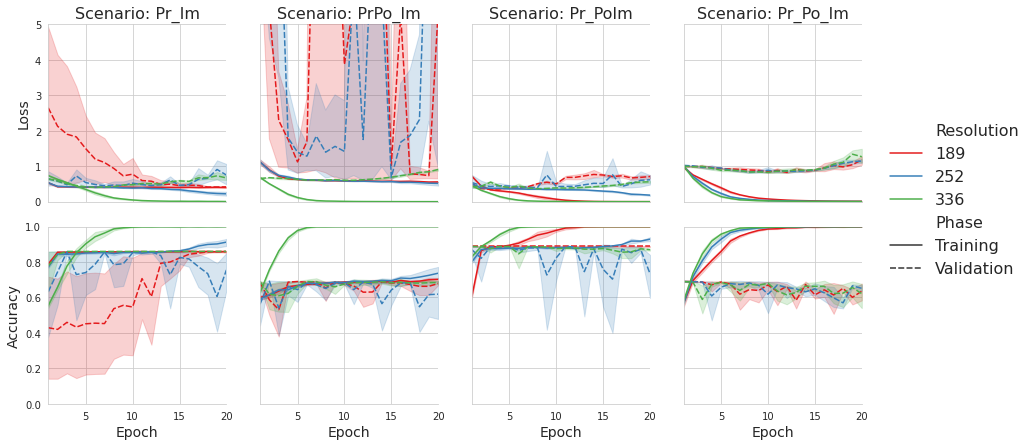

In [30]:
gg = plotMeanAccuracyLoss()

In [66]:
def plotMeanValidationMetric(metric="val_f1"):
    df = getPerformanceDataFrame()
    #df = df[df.epoch <16]
    melted_df = df.melt(id_vars = ["epoch", "width", "scenario", "trial"], value_vars = [metric], var_name = "metric", value_name = "value")
    melted_df["type"] = None
    num_scenarios = len(df.scenario.unique())
    num_resolutions = len(df.width.unique())
    num_epochs = df.epoch.max()
    sns.set_style("whitegrid")
    g = sns.FacetGrid(melted_df, col="scenario", sharey = True, col_order= ["Pr_Im", "PrPo_Im", "Pr_PoIm", "Pr_Po_Im"])
    g.map_dataframe(sns.lineplot, x = "epoch", y = "value", style = "metric",# style_order = ['Validation','Training'], 
                    hue = "width",# estimator=None, units='trial',
                    palette= sns.color_palette("Set1", n_colors=num_resolutions),
                   alpha=1)
    g.set_axis_labels("Epoch", "",  fontsize=14)
    g.add_legend( fontsize=16, bbox_to_anchor=(1.05, .5)) 
    ## Customize legend
    g._legend.texts[0].set_text("Resolution") #,prop={'weight':'bold'})
    g._legend.texts[num_resolutions + 1].set_text("") #, prop={'weight':'bold'}) #Data
    g._legend.texts[num_resolutions + 2].set_text("") 
    g._legend.legendHandles[num_resolutions + 1].set_linewidth(0)
    g._legend.legendHandles[num_resolutions + 2].set_linewidth(0)    
    g._legend._legend_box.sep = 5
    axes = g.axes
    for row, axlist in enumerate(axes):
        for col, axis in enumerate(axes[row]):
            #axes[row, col].set_ylim(0, 5)#.75 
            axes[row, col].set_xlim(1, num_epochs)
            axes[row, col].xaxis.set_major_locator(tkr.AutoLocator())
            axes[row, col].set_title("Scenario: " + 
                                     str(axes[row, col].title).split("scenario = ")[1].split(")")[0].split("\'")[0], fontsize=16)
            if col != 0:
                pass
                #axes[row, col].get_yaxis().set_ticklabels([])
            else:                    
                ylab = "Validation Macro-Avg. " + str.capitalize(str.split(metric, '_')[1])
                axes[row, col].set_ylabel(ylab, fontsize=14)
    g.savefig("../../figures/scenario_resolution_performance_" + metric + ".png", dpi=180)
    return(g)

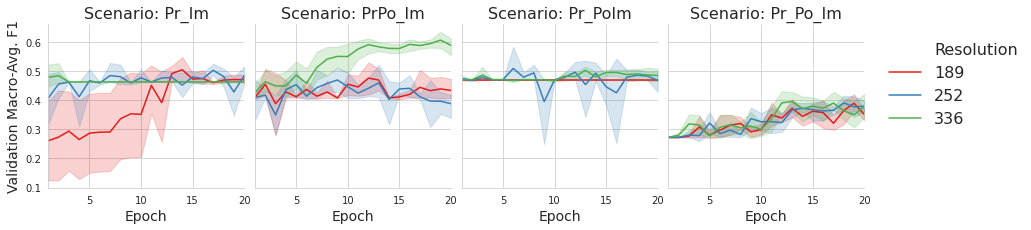

In [67]:
gg2 = plotMeanValidationMetric()

In [17]:
def testMeanValidationAccuracy():
    df = getPerformanceDataFrame()
    
    df = df[['scenario', "resolution", "trial", 'best_val_accuracy']].drop_duplicates()
    #df1['resolution'] = df1['resolution'].map(str)
    df = df.melt(id_vars = ['scenario', "resolution", "trial"], value_vars = ["best_val_accuracy"], var_name = "metric", value_name = "value")
    
    dfacc = df.groupby(["scenario", "resolution"]).mean()
    dfacc = dfacc.drop(["trial"], axis = 1)
    dfacc.columns = ['mean']
    dfacc['stdev'] = df.groupby(["scenario", "resolution"]).std()['value']
    print(np.round(dfacc,2))
    for s in SCENARIO_LIST:
        print(s)
        dfs = df[df.scenario==s]
        print("Test difference between resolutions 64 and 128")
        print(ttest_ind(dfs.loc[dfs.resolution==64,'value'], dfs.loc[dfs.resolution==128,'value'], equal_var=False))
        print("Test difference between resolutions 64 and 224")
        print(ttest_ind(dfs.loc[dfs.resolution==64,'value'], dfs.loc[dfs.resolution==224,'value'], equal_var=False))    
    return
testMeanValidationAccuracy()

KeyError: "['best_val_accuracy', 'resolution'] not in index"

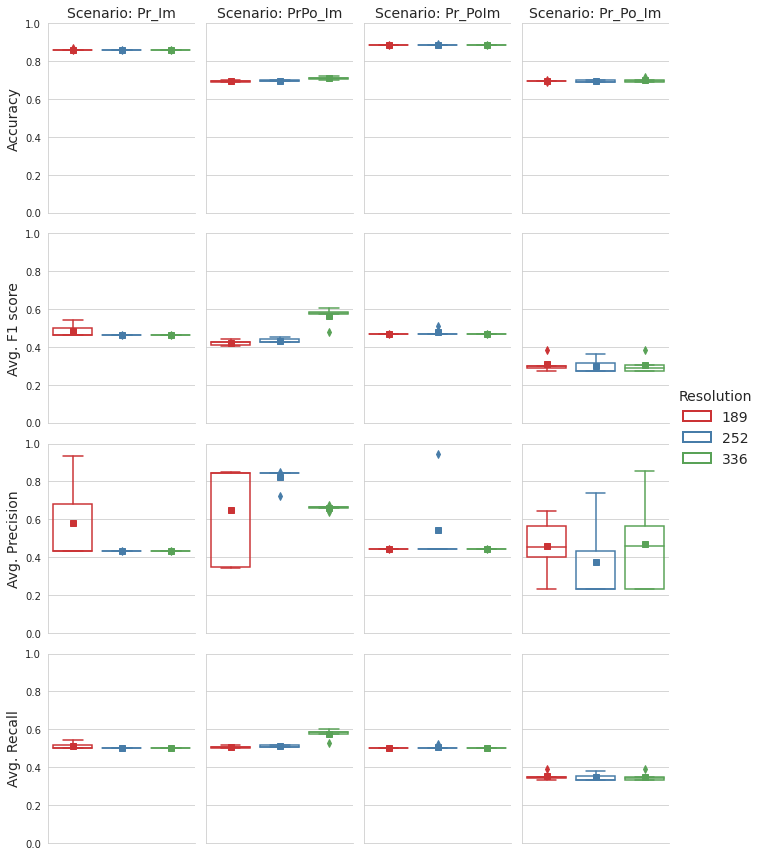

In [12]:
def plotSummaryValidationMetrics(type="box", facet=True, metrics="performance", objective="val_accuracy"):
    dp = getPerformanceDataFrame()    
    df = dp.loc[dp.groupby(['scenario','width','trial'])[objective].idxmax()]
    num_resolutions = len(dp.width.unique())
    sns.set_style("whitegrid")
    df.width = df.width.astype(object)
    if metrics=="performance":
        value_variables = ["val_accuracy", "val_f1", "val_precision", "val_recall"]
        row_labels = ["Accuracy", "Avg. F1 score", "Avg. Precision", "Avg. Recall"]
    else:
        value_variables = ["val_loss", "val_accuracy", "val_f1", "val_precision", "val_recall"]
        row_labels = ["Loss", "Accuracy", "Avg. F1 score", "Avg. Precision", "Avg. Recall"]
    #df = df[['scenario', "width", "trial", 'best_val_accuracy']].drop_duplicates()
    df = df.melt(id_vars = ['scenario','width','trial'], value_vars = value_variables,  var_name = "metric", value_name = "value")  
    #df = df.melt(id_vars = ['scenario', "width", "trial"], value_vars = [metric], var_name = "metric", value_name = "value")    
    if facet==True:
        g = sns.FacetGrid(df, col="scenario", row = "metric", sharey = True,  col_order= ["Pr_Im", "PrPo_Im", "Pr_PoIm", "Pr_Po_Im"], aspect=.8)
        if type=="box":
            g.map_dataframe(sns.boxplot, x = "width", y = "value", hue = "width", 
                        palette= sns.color_palette("Set1", n_colors=num_resolutions), dodge = False,
                        showmeans=True,meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"gray"})#, capsize = .2, errwidth=1.2)
            g.set(ylim =(0,1))
            g.add_legend(fontsize=14, title="Resolution", title_fontsize=16)#,bbox_to_anchor=(.9, .6), loc=2 )#, labels = row_labels) 
            #g._legend(title_fontsize=18)
        elif type=="point":
            g.map_dataframe(sns.pointplot, x = "width", y = "value",  capsize = .2, errwidth=1.2)
            g.set(ylim =(.89,1.0))       
        g.set_xticklabels([])
        #g.set_axis_labels("Resolution", "Validation Accuracy")
        axes = g.axes
        for row, axlist in enumerate(axes):
            for col, axis in enumerate(axes[row]):
                if col==0:
                    axes[row,0].set_ylabel(row_labels[row], fontsize=14)
                if row==0:
                    axes[row,col].set_title("Scenario: " + str(axes[row,col].title).split("scenario = ")[1].split(")")[0].split("\'")[0], fontsize=14)
                else:
                    axes[row,col].set_title("")
                # axes[-1, col].set_xlabel("Resolution")
                
                #Ref:https://stackoverflow.com/questions/36874697/how-to-edit-properties-of-whiskers-fliers-caps-etc-in-seaborn-boxplot
                for i,artist in enumerate(axis.artists):
                    # Set the linecolor on the artist to the facecolor, and set the facecolor to None
                    col = artist.get_facecolor()
                    artist.set_edgecolor(col)
                    artist.set_facecolor('None')

                    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
                    # Loop over them here, and use the same colour as above
                    # JO: now this is 7 because of square marker indicating mean value
                    for j in range(i*7, i*7 + 7):
                        line = axis.lines[j]
                        line.set_color(col)
                        line.set_mfc(col)
                        line.set_mec(col)

        # Also fix the legend
        g.legend.set_title('Resolution',prop={'size':14})
        for legpatch in g.legend.get_patches():
            col = legpatch.get_facecolor()
            legpatch.set_edgecolor(col)
            legpatch.set_linewidth(2)
            legpatch.set_facecolor('None')

        g.tight_layout()
        g.savefig("../../figures/scenario_resolution_performance_metrics_facet_" + type + "obj_" + objective + "plot.png", dpi=180)
    elif facet==False:
        #plt.figure(figsize=(14,4))
        #ax = plt.subplot(121)
        if type=="box":
            g = sns.boxplot( x = "scenario", y = "value", hue = "width", data = df, 
                            showmeans=True,meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"gray"},
                            palette= sns.color_palette("Set1", n_colors=num_resolutions))#, ax=ax)
        elif type=="bar":
            g = sns.barplot( x = "scenario", y = "value", hue = "width", data = df,  ci=None, order= ["Pr_Im", "PrPo_Im", "Pr_PoIm", "Pr_Po_Im"],
                            #showmeans=True,meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"gray"},
                            palette= sns.color_palette("Set1", n_colors=num_resolutions))#, ax=ax)
            g.set(yticks = np.arange(0,1,.1))
        elif type=="point":
            g = sns.pointplot(x = "scenario", y = "value", hue = "width", data = df, palette= sns.color_palette("Set1", n_colors=num_resolutions), dodge=True,capsize = .2, errwidth=1.2, boxprops=dict(alpha=.3))#, ax=ax)            
        g.legend(bbox_to_anchor=(1.05, 1), loc=2, title= "Resolution",borderaxespad=0.)
        g.set(xlabel="Scenario", ylabel="Validation Accuracy")
        g.get_figure().tight_layout()
        g.get_figure().savefig("../../figures/scenario_resolution_performance_metrics" + type + "plot.png", dpi=180)
    return
plotSummaryValidationMetrics()

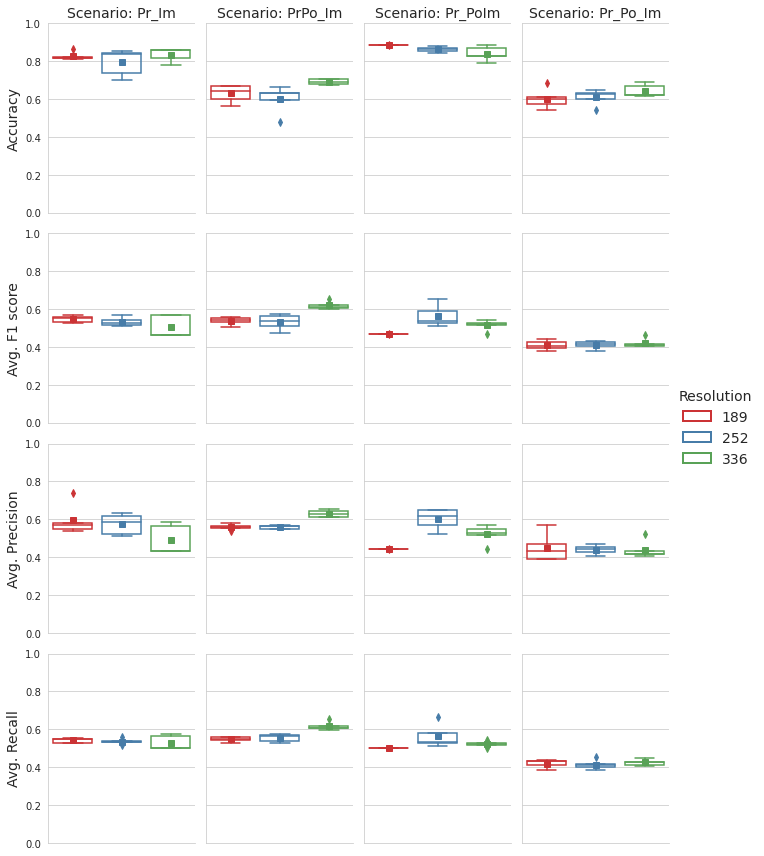

In [13]:
plotSummaryValidationMetrics(objective="val_f1")

In [91]:
def plotSummaryValidationAccuracy(type="box", facet=True, metric="val_accuracy"):
    df = getPerformanceDataFrame()    
    df = dp.groupby(['resolution','scenario','trial']).agg('max')
    df = df.reset_index()
    #df = df[['scenario', "resolution", "trial", 'best_val_accuracy']].drop_duplicates()
    num_resolutions = 3#len(df.resolution.unique())
    df.resolution = df.resolution.astype(object)
    df = df.melt(id_vars = ['scenario', "resolution", "trial"], value_vars = [metric], var_name = "metric", value_name = "value")    
    if facet==True:
        g = sns.FacetGrid(df, col="scenario", sharey = True,  col_order= ["Pr_Im", "PrPo_Im", "Pr_PoIm", "Pr_Po_Im"])
        if type=="box":
            g.map_dataframe(sns.boxplot, x = "resolution", y = "value", hue = "resolution", 
                        palette= sns.color_palette("Set1", n_colors=num_resolutions), dodge =False,
                        showmeans=True,meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"gray"})#, capsize = .2, errwidth=1.2)
            g.set(ylim =(.85,1.01))
        elif type=="point":
            g.map_dataframe(sns.pointplot, x = "resolution", y = "value",  capsize = .2, errwidth=1.2)
            g.set(ylim =(.89,1.0))        
        g.set_axis_labels("Resolution", "Validation Accuracy")
        axes = g.axes
        for row, axlist in enumerate(axes):
            for col, axis in enumerate(axes[row]):
                axes[row,col].set_title("Scenario: " + 
                                     str(axes[row,col].title).split("scenario = ")[1].split(")")[0].split("\'")[0])
        g.savefig("../../figures/scenario_resolution_validation_accuracy_facet_" + type + "plot.png", dpi=180)
    elif facet==False:
        #plt.figure(figsize=(14,4))
        #ax = plt.subplot(121)
        if type=="box":
            g = sns.boxplot( x = "scenario", y = "value", hue = "resolution", data = df, 
                            showmeans=True,meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"gray"},
                            palette= sns.color_palette("Set1", n_colors=num_resolutions))#, ax=ax)
        elif type=="bar":
            g = sns.barplot( x = "scenario", y = "value", hue = "resolution", data = df,  ci=None, order= ["Pr_Im", "PrPo_Im", "Pr_PoIm", "Pr_Po_Im"],
                            #showmeans=True,meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"gray"},
                            palette= sns.color_palette("Set1", n_colors=num_resolutions))#, ax=ax)
            g.set(yticks = np.arange(0,1,.1))
        elif type=="point":
            g = sns.pointplot(x = "scenario", y = "value", hue = "resolution", data = df, palette= sns.color_palette("Set1", n_colors=num_resolutions), dodge=True,capsize = .2, errwidth=1.2, boxprops=dict(alpha=.3))#, ax=ax)            
        g.legend(bbox_to_anchor=(1.05, 1), loc=2, title= "Resolution",borderaxespad=0.)
        g.set(xlabel="Scenario", ylabel="Validation Accuracy")
        g.get_figure().tight_layout()
        g.get_figure().savefig("../../figures/scenario_resolution_validation_accuracy_" + type + "plot.png", dpi=180)
    return

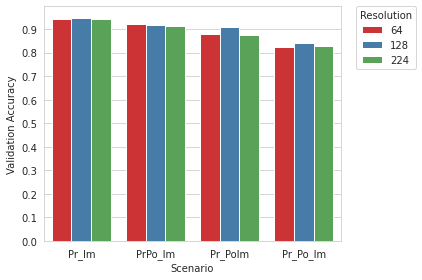

In [92]:
plotSummaryValidationAccuracy("bar", facet=False)

In [96]:
plotSummaryValidationAccuracy("box", facet=False)
#plotSummaryValidationAccuracy("point", facet=True)

NameError: name 'plotSummaryValidationAccuracy' is not defined

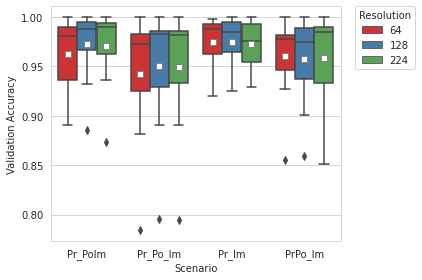

In [223]:
plotSummaryValidationAccuracy("box", facet=False)

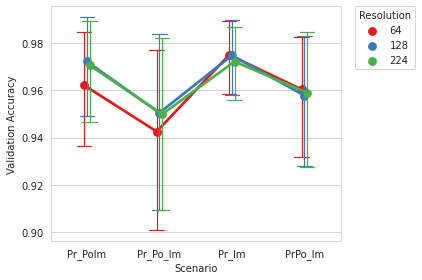

In [224]:
plotSummaryValidationAccuracy("point", facet=False)